In [61]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot

RANDOM_SEED = 42

# Export Configuration

Configure which model formats to export. Multiple formats can be enabled simultaneously.

In [62]:
# ============================================
# EXPORT CONFIGURATION
# ============================================

# Quantization Options
EXPORT_INT8_FULL = False
EXPORT_FP16 = False
EXPORT_DYNAMIC = False
EXPORT_INT8_PRUNED = True
EXPORT_FP16_PRUNED = True

# Edge TPU Compilation
COMPILE_EDGE_TPU = True          # Compile INT8 models for Coral TPU

# Pruning Configuration (if enabled)
PRUNING_INITIAL_SPARSITY = 0.0   # Start with 0% sparsity
PRUNING_FINAL_SPARSITY = 0.5     # End with 50% sparsity
PRUNING_BEGIN_STEP = 0
PRUNING_END_STEP = 1000
PRUNING_FREQUENCY = 100

# 各パス指定

In [63]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 分類数設定

In [64]:
NUM_CLASSES = 4

# 入力長

In [65]:
TIME_STEPS = 16
DIMENSION = 2

# 学習データ読み込み

In [66]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [67]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [69]:
# Check if pruning is enabled
USE_PRUNING = EXPORT_INT8_PRUNED or EXPORT_FP16_PRUNED
use_lstm = False

if USE_PRUNING:
    print("⚙️  Training with pruning enabled")
    
    # Build base model
    if use_lstm:
        base_model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
            tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(16, time_major=False, return_sequences=True),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
    else:
        base_model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
    
    # Apply pruning
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=PRUNING_INITIAL_SPARSITY,
            final_sparsity=PRUNING_FINAL_SPARSITY,
            begin_step=PRUNING_BEGIN_STEP,
            end_step=PRUNING_END_STEP,
            frequency=PRUNING_FREQUENCY
        )
    }
    
    model = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)
    print(f"  Pruning: {PRUNING_INITIAL_SPARSITY*100}% → {PRUNING_FINAL_SPARSITY*100}% sparsity")
else:
    print("⚙️  Training without pruning")
    if use_lstm:
        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
            tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(16, time_major=False, return_sequences=True),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
        ])

⚙️  Training with pruning enabled
  Pruning: 0.0% → 50.0% sparsity


In [70]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dropout  (None, 32)               1         
 _6 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_7  (None, 24)               1562      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dropout  (None, 24)               1         
 _7 (PruneLowMagnitude)                                          
                                                                 
 prune_low_magnitude_dense_8  (None, 10)               492       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_9  (None, 4)               

In [71]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

# Add pruning callback if pruning is enabled
callbacks_list = [cp_callback, es_callback]
if USE_PRUNING:
    import tensorflow_model_optimization as tfmot
    pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()
    callbacks_list.append(pruning_callback)
    print("Added pruning callback")

Added pruning callback


In [72]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [73]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list
)

Epoch 1/1000
28/32 [=========================>....] - ETA: 0s - loss: 1.3678 - accuracy: 0.4459
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 2s 10ms/step - loss: 1.3663 - accuracy: 0.4486 - val_loss: 1.3530 - val_accuracy: 0.5506
Epoch 2/1000
24/32 [=====================>........] - ETA: 0s - loss: 1.3449 - accuracy: 0.5036
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 1.3425 - accuracy: 0.5010 - val_loss: 1.3221 - val_accuracy: 0.5853
Epoch 3/1000
31/32 [============================>.] - ETA: 0s - loss: 1.3123 - accuracy: 0.5181
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.hdf5
32/32 [==============================] - 0s 10ms/step - loss: 1.3123 - accuracy: 0.5179 - val_loss: 1.2874 - val_accuracy: 0.6065
Epoch 4/1000
24/32 [=====================>........] - ETA: 0s - 

In [74]:
# 保存したモデルのロード
if USE_PRUNING:
    import tensorflow_model_optimization as tfmot
    with tfmot.sparsity.keras.prune_scope():
        model = tf.keras.models.load_model(model_save_path)
else:
    model = tf.keras.models.load_model(model_save_path)

In [75]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 91ms/step
[0.9254498  0.02250926 0.0246009  0.02744014]
0


# 混同行列

## 1. 非LSTM

42/42 [==============================] - 0s 2ms/step


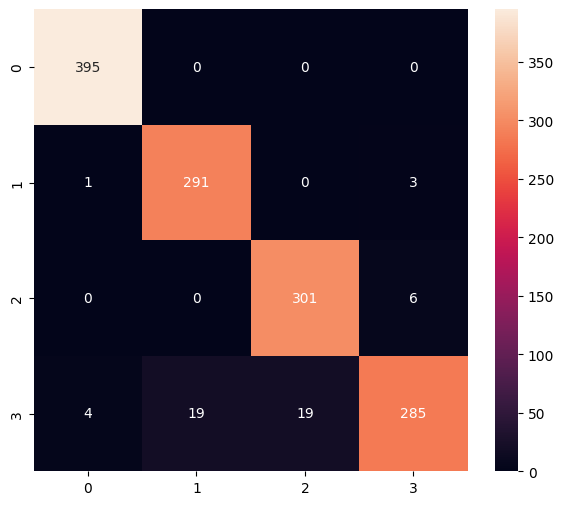

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.94      0.99      0.96       295
           2       0.94      0.98      0.96       307
           3       0.97      0.87      0.92       327

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## 2. LSTM

42/42 [==============================] - 0s 2ms/step


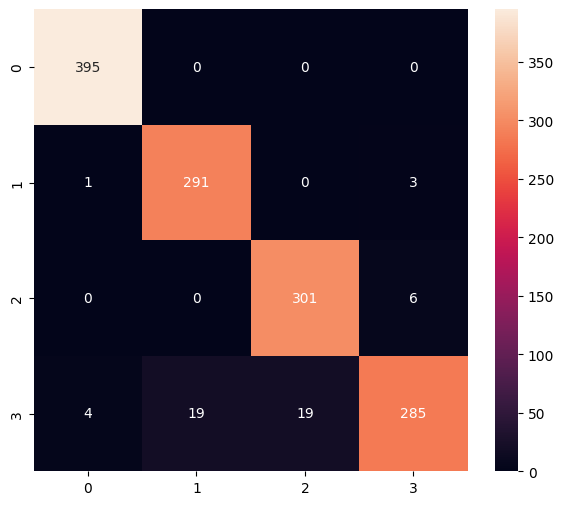

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       395
           1       0.94      0.99      0.96       295
           2       0.94      0.98      0.96       307
           3       0.97      0.87      0.92       327

    accuracy                           0.96      1324
   macro avg       0.96      0.96      0.96      1324
weighted avg       0.96      0.96      0.96      1324



In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [78]:
# Save model without optimizer for conversion
model.save(model_save_path, include_optimizer=False)
print(f"Saved model to {model_save_path}")

Saved model to model/point_history_classifier/point_history_classifier.hdf5


In [79]:
# Representative dataset generator for INT8 quantization
def representative_dataset_gen():
    """Generate representative dataset for INT8 quantization (sequence data)."""
    for i in range(min(100, len(X_train))):
        # Reshape for LSTM if needed
        yield [X_train[i:i+1].astype(np.float32)]

In [80]:
import subprocess
import os

exported_models = []
base_path = "model/point_history_classifier/point_history_classifier"

print("=" * 60)
print("Starting Model Export Process")
print("=" * 60)

# 1. Dynamic Range Quantization (Default)
# 1. Dynamic Range Quantization (Default)
if EXPORT_DYNAMIC:
    print("\n[1/5] Exporting Dynamic Range Quantization...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Handle LSTM models - allow SELECT_TF_OPS for dynamic operations
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS  # Required for LSTM
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    tflite_model = converter.convert()
    
    save_path = f"{base_path}.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model)
    exported_models.append(save_path)
    print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    save_path = f"{base_path}.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model)
    print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")

# 2. INT8 Full Quantization
if EXPORT_INT8_FULL:
    print("\n[2/5] Exporting INT8 Full Quantization...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    tflite_model = converter.convert()
    
    save_path = f"{base_path}_int8.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model)
    print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")
    
    # Try Edge TPU compilation
    if COMPILE_EDGE_TPU:
        print("    Attempting Edge TPU compilation...")
        try:
            result = subprocess.run(
                ["edgetpu_compiler", save_path, "-o", "model/point_history_classifier"],
                capture_output=True,
                text=True,
                timeout=30
            )
            if result.returncode == 0:
                edgetpu_path = f"{base_path}_int8_edgetpu.tflite"
                if os.path.exists(edgetpu_path):
                    exported_models.append(edgetpu_path)
                    print(f"    ✓ Edge TPU model: {edgetpu_path}")
            else:
                print(f"    ⚠ Edge TPU compilation failed: {result.stderr}")
        except FileNotFoundError:
            print("    ⚠ edgetpu_compiler not found. Install from: https://coral.ai/docs/edgetpu/compiler/")
        except Exception as e:
            print(f"    ⚠ Edge TPU compilation error: {e}")

# 3. FP16 Quantization
if EXPORT_FP16:
    print("\n[3/5] Exporting FP16 Quantization...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    converter._experimental_lower_tensor_list_ops = False
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_model = converter.convert()
    
    save_path = f"{base_path}_fp16.tflite"
    with open(save_path, "wb") as f:
        f.write(tflite_model)
    print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")

# 4. INT8 with Pruning
if EXPORT_INT8_PRUNED:
    if USE_PRUNING:
        print("\n[4/5] Exporting INT8 with Pruning...")
        import tensorflow_model_optimization as tfmot
        model_for_export = tfmot.sparsity.keras.strip_pruning(model)
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_model = converter.convert()
        
        save_path = f"{base_path}_int8_pruned.tflite"
        with open(save_path, "wb") as f:
            f.write(tflite_model)
        print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")
        
        if COMPILE_EDGE_TPU:
            print("    Attempting Edge TPU compilation...")
            try:
                result = subprocess.run(
                    ["edgetpu_compiler", save_path, "-o", "model/point_history_classifier"],
                    capture_output=True,
                    text=True,
                    timeout=30
                )
                if result.returncode == 0:
                    edgetpu_path = f"{base_path}_int8_pruned_edgetpu.tflite"
                    if os.path.exists(edgetpu_path):
                        exported_models.append(edgetpu_path)
                        print(f"    ✓ Edge TPU model: {edgetpu_path}")
                else:
                    print(f"    ⚠ Edge TPU compilation failed: {result.stderr}")
            except FileNotFoundError:
                print("    ⚠ edgetpu_compiler not found")
            except Exception as e:
                print(f"    ⚠ Edge TPU compilation error: {e}")
    else:
        print("\n[4/5] INT8 with Pruning requires training with pruning enabled.")
        print("  ℹ Set EXPORT_INT8_PRUNED=True and re-run training.")

# 5. FP16 with Pruning
if EXPORT_FP16_PRUNED:
    if USE_PRUNING:
        print("\n[5/5] Exporting FP16 with Pruning...")
        import tensorflow_model_optimization as tfmot
        model_for_export = tfmot.sparsity.keras.strip_pruning(model)
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        tflite_model = converter.convert()
        
        save_path = f"{base_path}_fp16_pruned.tflite"
        with open(save_path, "wb") as f:
            f.write(tflite_model)
        print(f"  ✓ Saved: {save_path} ({len(tflite_model)} bytes)")
    else:
        print("\n[5/5] FP16 with Pruning requires training with pruning enabled.")
        print("  ℹ Set EXPORT_FP16_PRUNED=True and re-run training.")

if EXPORT_FP16_PRUNED:
    print("\n[5/5] FP16 with Pruning requires retraining with pruning enabled.")
    print("  ℹ Set up pruning before training and re-run this notebook.")

print("\n" + "=" * 60)
print(f"Export Complete! Generated {len(exported_models)} model(s):")
print("=" * 60)
for model_path in exported_models:
    size_kb = os.path.getsize(model_path) / 1024
    print(f"  • {os.path.basename(model_path)}: {size_kb:.2f} KB")

Starting Model Export Process

[4/5] Exporting INT8 with Pruning...
INFO:tensorflow:Assets written to: /tmp/tmpkccl40uj/assets


INFO:tensorflow:Assets written to: /tmp/tmpkccl40uj/assets
/home/mat/Documents/iot/hand-gesture-recognition-mediapipe/.env/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2026-01-07 16:43:09.227752: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2026-01-07 16:43:09.227802: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2026-01-07 16:43:09.227978: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkccl40uj
2026-01-07 16:43:09.228910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2026-01-07 16:43:09.228923: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkccl40uj
2026-01-07 16:43:09.2

  ✓ Saved: model/point_history_classifier/point_history_classifier_int8_pruned.tflite (4056 bytes)
    Attempting Edge TPU compilation...
    ✓ Edge TPU model: model/point_history_classifier/point_history_classifier_int8_pruned_edgetpu.tflite

[5/5] Exporting FP16 with Pruning...
INFO:tensorflow:Assets written to: /tmp/tmpe4axbrxo/assets


INFO:tensorflow:Assets written to: /tmp/tmpe4axbrxo/assets
2026-01-07 16:43:09.986958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2026-01-07 16:43:09.986980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2026-01-07 16:43:09.987080: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe4axbrxo
2026-01-07 16:43:09.987703: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2026-01-07 16:43:09.987714: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe4axbrxo
2026-01-07 16:43:09.989816: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2026-01-07 16:43:10.001861: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe4axbrxo
2026-01-07 16:43:10.005723: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

  ✓ Saved: model/point_history_classifier/point_history_classifier_fp16_pruned.tflite (5208 bytes)

[5/5] FP16 with Pruning requires retraining with pruning enabled.
  ℹ Set up pruning before training and re-run this notebook.

Export Complete! Generated 1 model(s):
  • point_history_classifier_int8_pruned_edgetpu.tflite: 40.59 KB
